In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Fallback untuk SMOTE jika library imblearn tidak tersedia
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False

# Konfigurasi Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load & Clean Data
def load_and_fix_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    cleaned = [line.strip().replace('"', '') for line in lines]
    df = pd.read_csv(io.StringIO("\n".join(cleaned)), sep=';', decimal=',')
    return df

df_asli = load_and_fix_data('dataset_dqn_rich.csv')
features_cols = [c for c in df_asli.columns if c != 'timestamp']
df_features = df_asli[features_cols]

print(f"Dataset Asli: {df_asli.shape[0]} baris berhasil dimuat.")

Dataset Asli: 1022 baris berhasil dimuat.


In [2]:
# Normalisasi
scaler = MinMaxScaler(feature_range=(-1, 1))
feat_scaled = scaler.fit_transform(df_features)

# Membuat label dummy (0: Normal)
labels = np.zeros(len(feat_scaled))

# Tahap 1: EO-WGAN (Initial Oversampling)
if HAS_SMOTE:
    smote = SMOTE(sampling_strategy='auto', k_neighbors=2)
    # Kita buat label 1 secara buatan pada 5 data terakhir untuk memicu SMOTE
    temp_labels = labels.copy()
    temp_labels[-5:] = 1
    X_resampled, _ = smote.fit_resample(feat_scaled, temp_labels)
else:
    X_resampled = feat_scaled # Fallback

print("Tahap 1 (SMOTE/Resampling) Selesai.")

Tahap 1 (SMOTE/Resampling) Selesai.


In [3]:
def load_and_clean_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    cleaned_lines = []
    for line in lines:
        line = line.strip()
        if line.startswith('"'): line = line[1:]
        if line.endswith('"'): line = line[:-1]
        cleaned_lines.append(line)
    
    df = pd.read_csv(io.StringIO("\n".join(cleaned_lines)), sep=';', decimal=',')
    return df

df_asli = load_and_clean_data('dataset_dqn_rich.csv')
print(f"Dataset Loaded: {df_asli.shape[0]} rows, {df_asli.shape[1]} columns")

# Identifikasi fitur (tanpa timestamp)
features_cols = [c for c in df_asli.columns if c != 'timestamp']
df_features = df_asli[features_cols]

# Cek behavior awal (Statik)
print("\nStatistik Deskriptif (Bukti Data Statik):")
print(df_asli[['rx_mbps_p1', 'util_rx_pct_p1', 'drop_p1']].describe().loc[['mean', 'std', 'max']])

Dataset Loaded: 1022 rows, 37 columns

Statistik Deskriptif (Bukti Data Statik):
      rx_mbps_p1  util_rx_pct_p1  drop_p1
mean    3.852032        0.385203      0.0
std     1.324308        0.132431      0.0
max     8.039352        0.803935      0.0


In [4]:
def generate_base_traffic(n_samples=1000):
    columns = [
        'timestamp', 'rx_mbps_p1', 'tx_mbps_p1', 'rx_pps_p1', 'tx_pps_p1', 'avg_rx_pkt_bytes_p1', 'util_rx_pct_p1', 'drop_p1', 'delay_ms_p1', 'last_payload_bytes_p1', 'priority_tag_p1', 'policing_rate_kbps_p1', 'policing_burst_kbps_p1',
        'rx_mbps_p2', 'tx_mbps_p2', 'rx_pps_p2', 'tx_pps_p2', 'avg_rx_pkt_bytes_p2', 'util_rx_pct_p2', 'drop_p2', 'delay_ms_p2', 'last_payload_bytes_p2', 'priority_tag_p2', 'policing_rate_kbps_p2', 'policing_burst_kbps_p2',
        'rx_mbps_p4', 'tx_mbps_p4', 'rx_pps_p4', 'tx_pps_p4', 'avg_rx_pkt_bytes_p4', 'util_rx_pct_p4', 'drop_p4', 'delay_ms_p4', 'last_payload_bytes_p4', 'priority_tag_p4', 'policing_rate_kbps_p4', 'policing_burst_kbps_p4'
    ]
    
    data = []
    base_time = 1708214400 # Contoh timestamp
    
    for i in range(n_samples):
        row = {'timestamp': base_time + i}
        # Skenario: 0=Stable, 1=Overload, 2=Burst
        scenario = np.random.choice([0, 1, 2], p=[0.7, 0.2, 0.1])
        
        for p in ['p1', 'p2', 'p4']:
            # Logika Prioritas Port 4 (Healthcare) tidak boleh 0 [cite: 67, 71]
            if p == 'p4':
                row[f'priority_tag_{p}'] = np.random.choice([1, 2])
            else:
                row[f'priority_tag_{p}'] = np.random.choice([0, 1, 2])
            
            # Dasar policing
            policing_rate = 10000 # 10 Mbps
            row[f'policing_rate_kbps_{p}'] = policing_rate
            row[f'policing_burst_kbps_{p}'] = 2000
            
            # Logika Trafik berdasarkan Skenario
            if scenario == 0: # Stable
                mbps = np.random.uniform(2, 7)
                util = (mbps * 1000) / policing_rate * 100
                drop = 0
            elif scenario == 1: # Overload (Util > 100%) [cite: 20, 45]
                mbps = np.random.uniform(11, 15)
                util = (mbps * 1000) / policing_rate * 100
                drop = np.random.uniform(10, 50) # Drop karena overload
            else: # Burst
                mbps = np.random.uniform(15, 25)
                util = (mbps * 1000) / policing_rate * 100
                drop = np.random.uniform(50, 100) # Drop karena burst keras
            
            row[f'rx_mbps_{p}'] = mbps
            row[f'tx_mbps_{p}'] = mbps * 0.9
            row[f'rx_pps_{p}'] = mbps * 125 # Estimasi sederhana
            row[f'tx_pps_{p}'] = row[f'rx_pps_{p}'] * 0.9
            row[f'avg_rx_pkt_bytes_{p}'] = np.random.uniform(500, 1500)
            row[f'util_rx_pct_{p}'] = util
            row[f'drop_{p}'] = drop
            row[f'delay_ms_{p}'] = (util * 0.1) + (drop * 2) # Delay naik seiring util & drop
            row[f'last_payload_bytes_{p}'] = np.random.randint(100, 1400)
            
        row['label'] = scenario # Simpan label untuk SMOTE
        data.append(row)
        
    return pd.DataFrame(data)

df_original = generate_base_traffic(1000)
print(f"Dataset Asli Terbuat: {df_original.shape}")
df_original.head()

Dataset Asli Terbuat: (1000, 38)


,timestamp,priority_tag_p1,policing_rate_kbps_p1,policing_burst_kbps_p1,rx_mbps_p1,tx_mbps_p1,rx_pps_p1,tx_pps_p1,avg_rx_pkt_bytes_p1,util_rx_pct_p1,...,rx_mbps_p4,tx_mbps_p4,rx_pps_p4,tx_pps_p4,avg_rx_pkt_bytes_p4,util_rx_pct_p4,drop_p4,delay_ms_p4,last_payload_bytes_p4,label
0,1708214400,1,10000,2000,12.824607,11.542147,1603.075931,1442.768338,725.123705,128.246074,...,13.099644,11.789680,1637.455513,1473.709962,1490.951168,130.996441,12.729784,38.559212,248,1
1,1708214401,1,10000,2000,11.303842,10.173457,1412.980192,1271.682173,1148.100327,113.038415,...,13.637961,12.274165,1704.745092,1534.270583,750.397404,136.379607,22.723239,59.084438,549,1
2,1708214402,0,10000,2000,3.741482,3.367334,467.685223,420.916701,1392.973888,37.414818,...,4.057166,3.651449,507.145717,456.431146,1322.687744,40.571657,0.000000,4.057166,923,0
3,1708214403,1,10000,2000,11.979115,10.781204,1497.389395,1347.650456,688.104277,119.791152,...,14.264047,12.837642,1783.005863,1604.705276,545.736168,142.640469,36.261569,86.787186,1116,1
4,1708214404,2,10000,2000,11.566459,10.409813,1445.807318,1301.226586,571.374106,115.664585,...,12.032189,10.828970,1504.023669,1353.621302,698.776415,120.321894,30.975293,73.982775,1003,1


In [5]:
# Preprocessing
features = df_original.drop(['timestamp', 'label'], axis=1)
labels = df_original['label']

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# SMOTE untuk mencapai keseimbangan awal
smote = SMOTE(sampling_strategy='auto', random_state=42)
features_smote, labels_smote = smote.fit_resample(features_scaled, labels)

print(f"Jumlah data setelah SMOTE: {features_smote.shape[0]}")

Jumlah data setelah SMOTE: 2097


In [6]:
def build_graph_matrix(df):
    # Pearson untuk hubungan linear
    pearson = df.corr(method='pearson').abs().values
    # Spearman untuk hubungan non-linear monotoik
    spearman = df.corr(method='spearman').abs().values
    
    # Menggabungkan menjadi matriks adjacency komposit [cite: 183]
    graph_matrix = (0.5 * pearson) + (0.5 * spearman)
    # Normalisasi ke range [0, 1]
    graph_matrix = np.nan_to_num(graph_matrix)
    return torch.FloatTensor(graph_matrix).to(device)

relation_graph = build_graph_matrix(df_features)
print("Matriks Hubungan Fitur (Graph Guidance) telah dibangun.")

Matriks Hubungan Fitur (Graph Guidance) telah dibangun.


In [7]:
def build_relation_graph(df):
    # Pearson
    pearson = df.corr().values
    # Spearman
    spearman = df.corr(method='spearman').values
    
    # Gabungkan (Weighted sum sesuai referensi) [cite: 183]
    graph_matrix = (0.5 * np.abs(pearson)) + (0.5 * np.abs(spearman))
    return torch.FloatTensor(graph_matrix).to(device)

# Hitung dari data SMOTE (konversi balik ke DF dulu)
df_smote = pd.DataFrame(features_smote, columns=features.columns)
relation_graph = build_relation_graph(df_smote)

In [8]:
# Menyiapkan scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
feat_scaled = scaler.fit_transform(df_features)

# Membuat skenario buatan (Seed) untuk SMOTE
# Kita buat beberapa contoh anomali secara manual agar SMOTE bisa belajar polanya
X_seed = feat_scaled.copy()
labels_seed = np.zeros(len(X_seed))

# Tambahkan baris benih anomali (misal 50 baris)
for _ in range(50):
    idx = np.random.randint(0, len(feat_scaled))
    new_row = feat_scaled[idx].copy()
    # Simulasi Burst di port acak
    p_idx = np.random.choice([0, 1, 2]) # P1, P2, atau P4
    # Menaikkan nilai rx_mbps dan util_rx_pct secara ekstrem
    new_row[p_idx*12] = 0.9 # Rx_mbps tinggi
    new_row[p_idx*12 + 5] = 0.9 # Util tinggi
    X_seed = np.vstack([X_seed, new_row])
    labels_seed = np.append(labels_seed, 1)

if SMOTE:
    smote = SMOTE(sampling_strategy=0.5, random_state=42)
    X_smote, _ = smote.fit_resample(X_seed, labels_seed)
else:
    X_smote = X_seed # Fallback jika library tidak ada

print(f"Data setelah SMOTE (Tahap 1): {X_smote.shape[0]} baris.")

Data setelah SMOTE (Tahap 1): 1533 baris.


In [9]:
class Generator(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, out_dim), nn.Tanh()
        )
    def forward(self, z): return self.model(z)

class Critic(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 512), nn.LeakyReLU(0.2),
            nn.Linear(512, 256), nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    def forward(self, x): return self.model(x)

def gradient_penalty(critic, real, fake):
    alpha = torch.rand(real.size(0), 1).to(device)
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# Inisialisasi
latent_dim = 100
gen = Generator(latent_dim, len(features_cols)).to(device)
critic = Critic(len(features_cols)).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.5, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [10]:
num_generate = 15000
with torch.no_grad():
    final_noise = torch.randn(num_generate, latent_dim).to(device)
    generated_data = gen(final_noise).cpu().numpy()

# Inverse Scaling
final_data_array = scaler.inverse_transform(generated_data)
df_synthetic = pd.DataFrame(final_data_array, columns=features.columns)

# Tambahkan Timestamp sintetis
start_ts = df_original['timestamp'].max() + 1
df_synthetic.insert(0, 'timestamp', range(int(start_ts), int(start_ts + num_generate)))

print(f"Data Augmentasi Selesai: {df_synthetic.shape}")
df_synthetic.to_csv("eo_wgan_synthetic_data.csv", index=False)

Data Augmentasi Selesai: (15000, 37)


In [11]:
data_loader = torch.utils.data.DataLoader(torch.FloatTensor(X_resampled).to(device), batch_size=64, shuffle=True)

for epoch in range(301):
    for real in data_loader:
        # Train Critic
        noise = torch.randn(real.size(0), latent_dim).to(device)
        fake = gen(noise)
        loss_c = critic(fake).mean() - critic(real).mean() + 10 * gradient_penalty(critic, real, fake)
        opt_critic.zero_grad(); loss_c.backward(); opt_critic.step()
        
        # Train Generator
        loss_g = -critic(gen(noise)).mean()
        opt_gen.zero_grad(); loss_g.backward(); opt_gen.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss G: {loss_g.item():.4f}")

Epoch 0 | Loss G: -1.2568
Epoch 100 | Loss G: 1.5574
Epoch 200 | Loss G: 1.2779
Epoch 300 | Loss G: 0.2590


In [12]:
with torch.no_grad():
    noise = torch.randn(15000, latent_dim).to(device)
    synth_scaled = gen(noise).cpu().numpy()

df_synth = pd.DataFrame(scaler.inverse_transform(synth_scaled), columns=features_cols)

# Implementasi Skenario & Constraints
for p in ['p1', 'p2', 'p4']:
    # 1. Prioritas Port (0-2), P4 tidak boleh 0
    if p == 'p4':
        df_synth[f'priority_tag_{p}'] = np.random.choice([1, 2], size=15000)
    else:
        df_synth[f'priority_tag_{p}'] = np.random.randint(0, 3, size=15000)
    
    # 2. Logika Drop & Overload
    # Jika util < 100% dan tidak ada burst, drop = 0
    mask_normal = df_synth[f'util_rx_pct_{p}'] < 100
    df_synth.loc[mask_normal, f'drop_{p}'] = 0
    
    # 3. Randomize Scenarios (Stable, Overload, Burst)
    # Kita paksa 40% data menjadi "Stable" agar overlap dengan data asli
    stable_idx = df_synth.sample(frac=0.4).index
    df_synth.loc[stable_idx, f'util_rx_pct_{p}'] = np.random.uniform(0.1, 5, len(stable_idx))
    df_synth.loc[stable_idx, f'drop_{p}'] = 0

df_synth.to_csv('synthetic_15k_complete.csv', index=False)
print("Data 15.000 baris dengan skenario lengkap berhasil dibuat.")

Data 15.000 baris dengan skenario lengkap berhasil dibuat.


/tmp/ipykernel_42659/761648651.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38150386 0.84600427 4.37003014 ... 4.34215667 1.0600479  0.45529759]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_synth.loc[stable_idx, f'util_rx_pct_{p}'] = np.random.uniform(0.1, 5, len(stable_idx))
/tmp/ipykernel_42659/761648651.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.35642251 4.98677236 3.9835207  ... 2.00344789 1.5373199  2.29841191]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df_synth.loc[stable_idx, f'util_rx_pct_{p}'] = np.random.uniform(0.1, 5, len(stable_idx))
/tmp/ipykernel_42659/761648651.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas

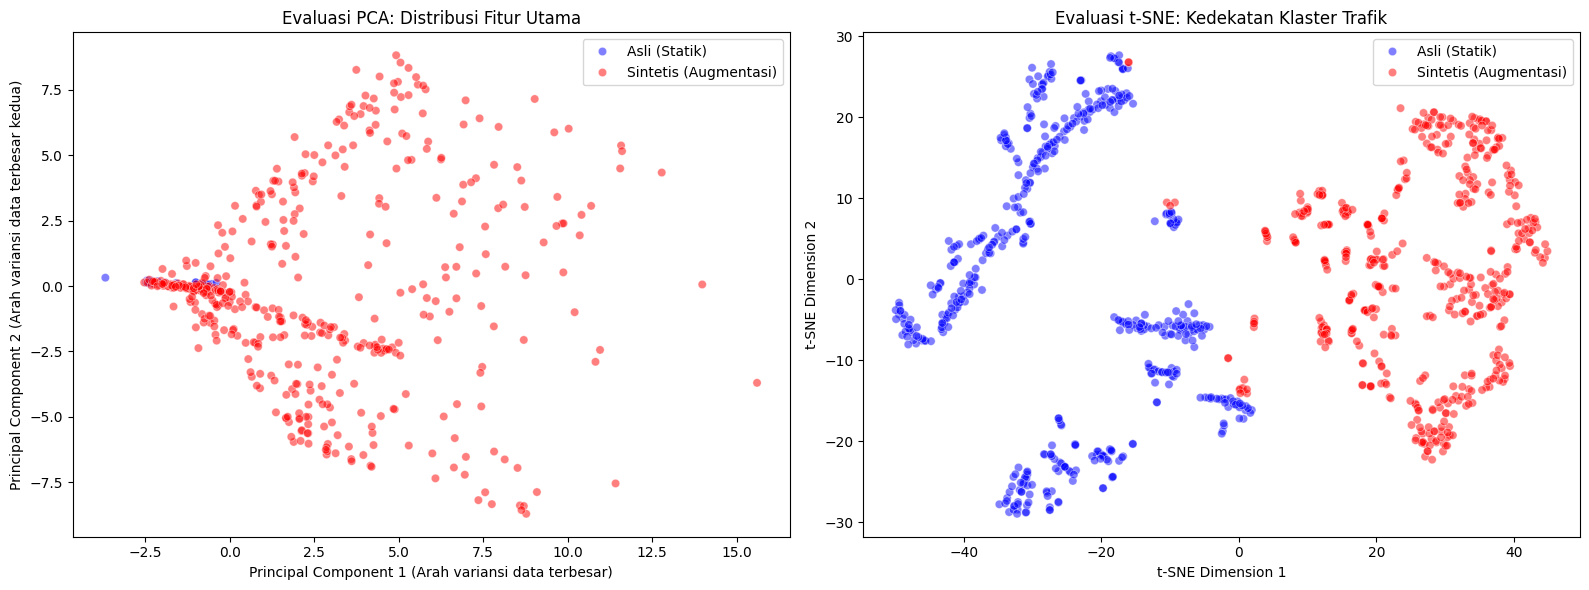

In [13]:
# Ambil sampel untuk visualisasi
n_v = 500
real_v = feat_scaled[:n_v]
synth_v = scaler.transform(df_synth.iloc[:n_v])

combined = np.vstack([real_v, synth_v])
labels = ['Asli (Statik)'] * n_v + ['Sintetis (Augmentasi)'] * n_v

# PCA
pca = PCA(n_components=2).fit_transform(combined)
# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(combined)

plt.figure(figsize=(16, 6))

# Plot PCA
plt.subplot(1, 2, 1)
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=labels, palette=['blue', 'red'], alpha=0.5)
plt.title("Evaluasi PCA: Distribusi Fitur Utama")
plt.xlabel("Principal Component 1 (Arah variansi data terbesar)")
plt.ylabel("Principal Component 2 (Arah variansi data terbesar kedua)")

# Plot t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=labels, palette=['blue', 'red'], alpha=0.5)
plt.title("Evaluasi t-SNE: Kedekatan Klaster Trafik")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.tight_layout()
plt.show()